In [1]:
# File : Digit_Recognizer_github
# Name : Yu-Ju Fang


In [2]:

# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Please enter the address of the file
FOLDERNAME = 'Colab\ Notebooks/digit_recognizer'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))


# if it doesn't already exist.
%cd drive/MyDrive/$FOLDERNAME
# !bash get_datasets.sh


Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/digit_recognizer


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

#pytorch utility imports
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid


In [4]:
#import external libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import math
%matplotlib inline

In [5]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cpu


### There will be five steps to train an digit recognizer
1. Load datasets
2. Define Convolutional Neural Network
3. Define Loss function and optimizer
4. Train the network on the training data
5. Test the network on the test data





# 1.Load datasets

In [6]:
# Load train.csv, test.csv, sample_submission.csv
train = pd.read_csv('train.csv', dtype=np.float32)
final_test = pd.read_csv('test.csv', dtype=np.float32)
sample_sub = pd.read_csv("sample_submission.csv")
# train.label.head()

In [7]:
# Seperate the features and labels
targets_np = train.label.values
features_np = train.loc[:, train.columns != 'label'].values/255
# final_test_np = final_test.values/255


# Split into training and test set
features_train, features_test, target_train, target_test = train_test_split(features_np, targets_np, test_size=0.2, random_state=42)

In [8]:
features_train = features_train.reshape(features_train.shape[0], 1, 28, 28)
print(features_train[0].squeeze().shape)
features_test = features_test.reshape(features_test.shape[0], 1, 28, 28)
# feature_final_test = final_test_np.reshape(final_test_np.shape[0], 1, 28, 28)

(28, 28)


In [9]:
# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable

featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(target_train).type(torch.LongTensor) # data type is long
print(featuresTrain.shape)

# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(target_test).type(torch.LongTensor) # data type is long


torch.Size([33600, 1, 28, 28])


In [10]:
# Set batch size
batch_size = 64

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = True)

# 2.Define Convolutional Neural Network

In [11]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 6, 3, 1, padding=1)
        self.batch1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, 3, 1, padding = 1)
        self.batch2 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 64, 3, 1, padding = 1)
        self.batch3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 3, 1, padding = 1)
        self.batch4 = nn.BatchNorm2d(64)

        self.fc1 = nn.Linear(64*7*7, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        # self.conv5 = nn.Conv2d(64, 128, 3, 1, padding = 1)
        # self.conv6 = nn.Conv2d(128, 128, 3, 1, padding = 1)
        # self.conv7 = nn.Conv2d(128, 256, 3, 1, padding = 1)
       

    def forward(self, x):
        # N * 1 * 28 * 28
        x = self.pool(F.relu(self.conv1(x)))
        x = self.batch1(x)

        # N * 6 * 14 * 14
        x = F.relu(self.conv2(x))
        x = self.batch2(x)

        # N * 16 * 14 * 14  
        x = F.relu(self.conv3(x))
        x = self.batch3(x)
        
        # N * 64 * 14 * 14  
        x = F.relu(self.conv4(x))
        x = self.batch4(x)    
        x = self.pool(F.relu(self.conv4(x)))

        # N * 64 * 7 * 7 
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
      


In [12]:
net = Net()

# 3. Define Loss function and optimizer

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0002)

In [17]:
epochs = 10
print_every = 50
train_losses, test_losses = [], []


# 4. Train the network on the training data

In [18]:
for epoch in range(epochs):  # loop over the dataset multiple times
    net.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % print_every == 0:    # print every 50 mini-batches
            test_loss = 0
            accuracy = 0

            # Turn off gradients for validation and test the accuracy of the current model with test dataset
            with torch.no_grad():
                net.eval()
                for images, labels in test_loader:
                    log_ps = net(images)
                    test_loss += criterion(log_ps, labels)

                    ps = torch.exp(log_ps)
                    # Get our top predictions
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor))

            net.train()

            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(test_loader))

            print("Epoch: {}/{}   ".format(epoch+1, epochs),
                  "Training Loss: {:.3f}.. ".format(train_losses[-1]),
                  "Test Loss: {:.3f}.. ".format(test_losses[-1]),
                  "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

print('Finished Training')

Epoch: 1/2    Training Loss: 0.000..  Test Loss: 0.128..  Test Accuracy: 0.960
Epoch: 1/2    Training Loss: 0.012..  Test Loss: 0.120..  Test Accuracy: 0.964
Epoch: 1/2    Training Loss: 0.023..  Test Loss: 0.102..  Test Accuracy: 0.969
Epoch: 1/2    Training Loss: 0.032..  Test Loss: 0.094..  Test Accuracy: 0.972
Epoch: 1/2    Training Loss: 0.040..  Test Loss: 0.088..  Test Accuracy: 0.973
Epoch: 1/2    Training Loss: 0.048..  Test Loss: 0.085..  Test Accuracy: 0.974
Epoch: 1/2    Training Loss: 0.056..  Test Loss: 0.072..  Test Accuracy: 0.979
Epoch: 1/2    Training Loss: 0.062..  Test Loss: 0.078..  Test Accuracy: 0.976
Epoch: 1/2    Training Loss: 0.068..  Test Loss: 0.072..  Test Accuracy: 0.979
Epoch: 1/2    Training Loss: 0.074..  Test Loss: 0.068..  Test Accuracy: 0.978
Epoch: 1/2    Training Loss: 0.079..  Test Loss: 0.070..  Test Accuracy: 0.978
Epoch: 2/2    Training Loss: 0.000..  Test Loss: 0.060..  Test Accuracy: 0.982
Epoch: 2/2    Training Loss: 0.006..  Test Loss: 0.0

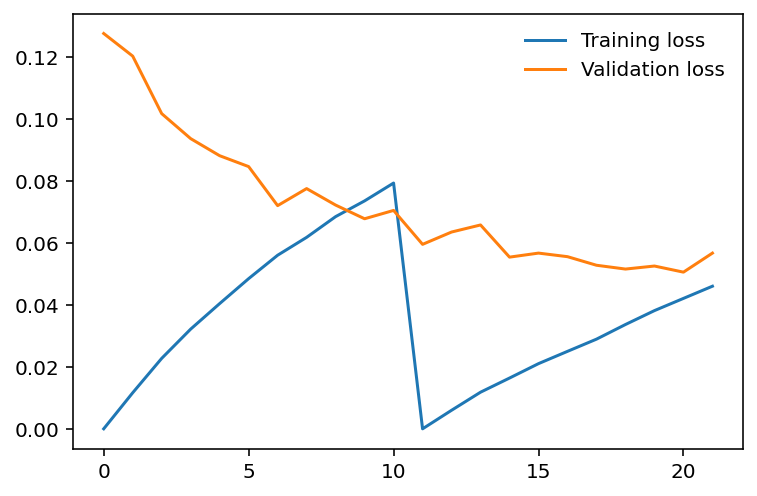

In [19]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

# 5. Test the network on the test data

In [20]:
final_test_np = final_test.values/255
feature_final_test = final_test_np.reshape(final_test_np.shape[0], 1, 28, 28)
test_tn = torch.from_numpy(feature_final_test)


In [21]:
# Creating fake labels for convenience of passing into DataLoader
fake_labels = np.zeros(final_test_np.shape)
fake_labels = torch.from_numpy(fake_labels)

In [22]:
submission_tn_data = torch.utils.data.TensorDataset(test_tn, fake_labels)
submission_loader = torch.utils.data.DataLoader(submission_tn_data, batch_size = batch_size, shuffle = False)


In [23]:
# Making it submission ready
submission = [['ImageId', 'Label']]

# Turn off gradients for validation
with torch.no_grad():
    net.eval()
    image_id = 1
    for images, _ in submission_loader:
        log_ps = net(images)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        
        for prediction in top_class:
            submission.append([image_id, prediction.item()])
            image_id += 1

### Outfile the result of prediction into csv file

In [24]:
submission_df = pd.DataFrame(submission)
submission_df.columns = submission_df.iloc[0]
submission_df = submission_df.drop(0, axis=0)

In [25]:
submission_df.to_csv("submission.csv", index=False)